# Assignment A3.1

Re-training the random forest model using feature selection, dropping columns that were deemed as the previous model as of little importance

In [8]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
sample_df = pd.read_csv('data/sample_df.csv')
sample_df = sample_df.drop(['listing_title_car', 'listing_title_credit_card',
       'listing_title_debt_consolidation', 'listing_title_educational',
       'listing_title_home_improvement', 'listing_title_house',
       'listing_title_major_purchase', 'listing_title_medical',
       'listing_title_moving', 'listing_title_other',
       'listing_title_renewable_energy', 'listing_title_small_business',
       'listing_title_unknown', 'listing_title_vacation',
       'listing_title_wedding', 'term_12', 'term_36', 'term_60'], axis=1)

X = sample_df.iloc[:,:-1]
y = sample_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [3]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [12]:
# Predict on training set
pred_y = model.predict(X_train)
# Is our model predicting just one class?
print(np.unique(pred_y))

[0 1]


In [13]:
# Predict on test set
pred_y = model.predict(X_test)
# Is our model predicting just one class?
print(np.unique(pred_y))

[0 1]


In [14]:
from sklearn.metrics import accuracy_score

In [15]:
# Predict on training set
pred_y = model.predict(X_train)
# How's our accuracy?
print(accuracy_score(y_train, pred_y))

0.9172819009812833


In [16]:
# Predict on test set
pred_y = model.predict(X_test)
# How's our accuracy?
print(accuracy_score(y_test, pred_y))

0.873620946312553


In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
# What about AUROC? (train set)
prob_y = model.predict_proba(X_train)
prob_y = [p[1] for p in prob_y]
print(roc_auc_score(y_train, prob_y))

0.903815629168656


In [19]:
# What about AUROC? (test set)
prob_y = model.predict_proba(X_test)
prob_y = [p[1] for p in prob_y]
print(roc_auc_score(y_test, prob_y))

0.6723881399819484


After feature dropping, auroc on test set went up 1%! (It still may be overfit, but its a start). Needs some tuning and evaluating how precision and recall are doing. For now, I'll just provide a word of caution on this and jump to do some plots.

In [15]:
# Feature names
features = X_train.columns

# Ranking calification of Decistion Tree model
ranking = model.feature_importances_

zipped = list(zip(features, ranking))

df = pd.DataFrame(zipped, columns = ['Features', 'Ranking']) 
   
# Order data according to ranking
df = df.sort_values(by='Ranking', ascending=False)
df

,Features,Ranking
2,installment,0.399993
1,borrower_rate,0.294865
0,amount_borrowed,0.260727
3,grade_A,0.011626
7,grade_E,0.008176
8,grade_F,0.006505
4,grade_B,0.005578
6,grade_D,0.005465
5,grade_C,0.005055
9,grade_G,0.002011


In [19]:
plt.xticks?

Signature: plt.xticks(ticks=None, labels=None, **kwargs)
Docstring:
Get or set the current tick locations and labels of the x-axis.

Call signatures::

    locs, labels = xticks()            # Get locations and labels
    xticks(ticks, [labels], **kwargs)  # Set locations and labels

Parameters
----------
ticks : array_like
    A list of positions at which ticks should be placed. You can pass an
    empty list to disable xticks.

labels : array_like, optional
    A list of explicit labels to place at the given *locs*.

**kwargs
    :class:`.Text` properties can be used to control the appearance of
    the labels.

Returns
-------
locs
    An array of label locations.
labels
    A list of `.Text` objects.

Notes
-----
Calling this function with no arguments (e.g. ``xticks()``) is the pyplot
equivalent of calling `~.Axes.get_xticks` and `~.Axes.get_xticklabels` on
the current axes.
Calling this function with arguments is the pyplot equivalent of calling
`~.Axes.set_xticks` and `~.Axes.se

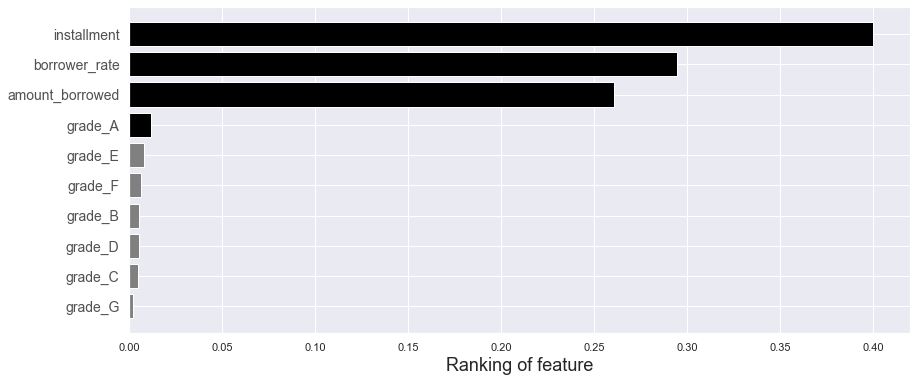

In [41]:
fig, ax = plt.subplots(figsize=(14,6))
labels = df['Features']
pos = np.arange(len(labels))
values=df['Ranking']
colors = ['black','black', 'black', 'black']
colors.extend(['grey']*(len(labels)-4))
ax.barh(labels, values, color=colors)
plt.xlabel('Ranking of feature', fontsize=18)
plt.yticks(pos, labels, alpha = 0.8, fontsize=14)
ax.invert_yaxis()
plt.savefig('graphics/FeatureRanking_General.png')

Another way to interpret this result is that grade of risk has a very low impact on the target variable. While installment has the highest and borrower_rate together with amount_borrowed have more or less similar importance. This could be an interesting insight, depending on the visualization, we may end up with some interesting graphs, the amount borrowed has the lowest impact out of the three of them.

Next question: ¿What could be the best combination of installment, borrower rate and amount borrowed that separates a good loan from one that will be defaulted?

A given but a visualization of it could be useful anyway, is that borrowers rated with grade A risk are indeed on low risk of defaulting their loans, but a surprising turn is that downwards from there, grades do not say much on the probability of it. That is very interesting

https://www.investopedia.com/articles/personal-finance/072316/how-installment-loans-work.asp

In [6]:
plot_df = sample_df.sample(frac=0.01)

In [7]:
plot_df.to_csv('data/plot_df.csv', index=False)

----------------------------------------------------------------------------------------------------

Trying idea on training a Random Forest Classifier in a set where the grades are reduced to either A or not A

In [5]:
X = sample_df.iloc[:,:-1]
y = sample_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [9]:
sample_df.head()

,amount_borrowed,borrower_rate,installment,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,status_binary
0,9425.0,0.1449,324.380000,0,0,1,0,0,0,0,1
1,8500.0,0.0532,255.980000,1,0,0,0,0,0,0,1
2,10000.0,0.1199,222.393947,0,0,1,0,0,0,0,1
3,10000.0,0.1081,326.488134,0,0,1,0,0,0,0,1
4,10000.0,0.1005,322.906670,0,1,0,0,0,0,0,0


In [10]:
binary_mirror = {0:1, 1:0}

In [11]:
sample_df2 = sample_df.iloc[:,0:4]
sample_df2['grade_notA'] = sample_df['grade_A'].map(binary_mirror)
sample_df2 = pd.concat([sample_df2, sample_df.iloc[:,-1]], axis=1)
sample_df2.head()

,amount_borrowed,borrower_rate,installment,grade_A,grade_notA,status_binary
0,9425.0,0.1449,324.380000,0,1,1
1,8500.0,0.0532,255.980000,1,0,1
2,10000.0,0.1199,222.393947,0,1,1
3,10000.0,0.1081,326.488134,0,1,1
4,10000.0,0.1005,322.906670,0,1,0


In [12]:
X = sample_df2.iloc[:,:-1]
y = sample_df2.iloc[:,-1]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [54]:
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [55]:
# Predict on test set
pred_y = model.predict(X_test)
# Is our model predicting just one class?
print(np.unique(pred_y))

[0 1]


In [56]:
# What about AUROC? (test set)
prob_y = model.predict_proba(X_test)
prob_y = [p[1] for p in prob_y]
print(roc_auc_score(y_test, prob_y))

0.6667232922749963


In [57]:
# Feature names
features = X_train.columns

# Ranking calification of Decistion Tree model
ranking = model.feature_importances_

zipped = list(zip(features, ranking))

df = pd.DataFrame(zipped, columns = ['Feature', 'Ranking']) 
   
# Order data according to ranking
df.sort_values(by='Ranking', ascending=False)

,Feature,Ranking
2,installment,0.415548
1,borrower_rate,0.333925
0,amount_borrowed,0.234437
3,grade_A,0.009995
4,grade_notA,0.006095


In [15]:
sample_df2 = sample_df.iloc[:,0:4]
sample_df2 = pd.concat([sample_df2, sample_df.iloc[:,-1]], axis=1)
sample_df2.head()

,amount_borrowed,borrower_rate,installment,grade_A,status_binary
0,9425.0,0.1449,324.380000,0,1
1,8500.0,0.0532,255.980000,1,1
2,10000.0,0.1199,222.393947,0,1
3,10000.0,0.1081,326.488134,0,1
4,10000.0,0.1005,322.906670,0,0


In [16]:
sample_df2.to_csv('data/regraded_sample_df.csv', index=False)